In [1]:
import yfinance as yf

# Download data from Yahoo Finance
stock_data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')


[*********************100%***********************]  1 of 1 completed


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the closing prices
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

# Split data into training (e.g., 80%) and test (e.g., 20%) sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [3]:
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape input to [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer to predict the next closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Train the model
model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0073 - val_loss: 0.0093
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.0719e-04 - val_loss: 0.0017
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 2.4357e-04 - val_loss: 0.0013
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 2.2243e-04 - val_loss: 0.0013
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 1.8500e-04 - val_loss: 0.0019
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 1.7950e-04 - val_loss: 0.0013
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 1.8345e-04 - val_loss: 0.0013
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 1.7329e-04 - val_loss: 0.0012
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 1.6176e-04 - val_loss: 0.0038
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 1.6260e-04 - val_loss: 0.0015
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 1.6953e-04 - val_loss: 0.0010
Epoch 12/1

In [6]:
# Make predictions
predictions = model.predict(X_test)

# Reverse the scaling to get actual stock price predictions
predictions = scaler.inverse_transform(predictions)

# Evaluate performance (example: calculating RMSE)
rmse = np.sqrt(np.mean(predictions - scaler.inverse_transform(Y_test.reshape(-1, 1)))**2)
print(f'Root Mean Squared Error: {rmse}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Root Mean Squared Error: 0.8334553137371438


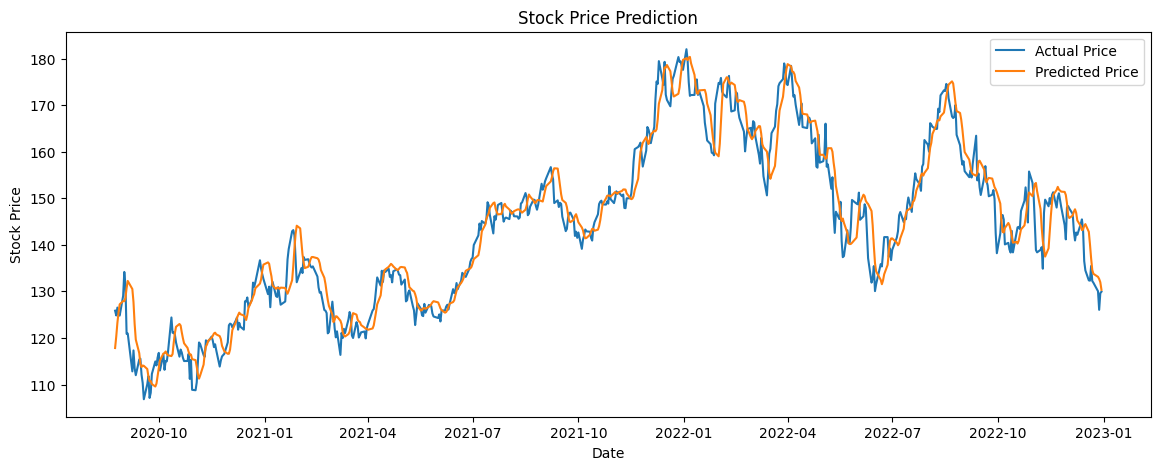

In [7]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14,5))
plt.plot(stock_data.index[-len(predictions):], scaler.inverse_transform(test_data[time_step+1:]), label='Actual Price')
plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
